# Can you identify question pairs that have the same intent?

![](https://www.kaggle.com/competitions/6277/images/header)

The following dataset come from a Kaggle's Competition called [Quora Question Pairs](https://www.kaggle.com/competitions/quora-question-pairs).


The dataset comprises **pairs of questions with the aim of predicting which pairs contain questions that share the same meaning**. These pairs have been labeled by human experts to indicate whether they are duplicates. However, the ground truth labels are inherently subjective because the true meaning of sentences cannot be known with absolute certainty. Human labeling introduces variability and noise, as individuals may interpret the meaning of questions differently, leading to reasonable disagreements.

As a result, the ground truth labels in this dataset should be considered informed but not entirely accurate, acknowledging the presence of potential mislabeling. While the labels are believed to represent a reasonable consensus overall, this may not hold true on a case-by-case basis for individual items within the dataset. This inherent subjectivity underscores the challenges in tasks involving semantic similarity and duplicate question detection.

I'll use just the `train` set because the `test` set hasn't the ground truth label, so there is not a way to compute performance metrics such as accuracy or recall.

For that reason, I'll develop the model (Universal Sentence Encoder) using `train` set for both training and evaluation.

# Setup

In [1]:
!pip install tensorflow transformers pytorch_lightning datasets evaluate tensorflow_text tensorflow_hub > /dev/null 2>&1

In [2]:
import pytorch_lightning as pl

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from typing import List, Dict

In [3]:
SEED = 42

In [4]:
TARGET = "is_duplicate"

In [5]:
pl.seed_everything(SEED, workers=True)

INFO:lightning_fabric.utilities.seed:Seed set to 42


42

In [6]:
pd.set_option("display.max_columns", None)
pd.set_option("display.max_colwidth", 250)

# Data Collection

In [7]:
DATA_PATH = "/content/drive/MyDrive/Colab Notebooks/Transformers/USE family/same-intention-detection/train.csv"

In [8]:
df_questions = pd.read_csv(DATA_PATH)

In [9]:
df_questions.shape

(404290, 6)

In [10]:
df_questions.head(4)

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in share market in india?,What is the step by step guide to invest in share market?,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Diamond?,What would happen if the Indian government stole the Kohinoor (Koh-i-Noor) diamond back?,0
2,2,5,6,How can I increase the speed of my internet connection while using a VPN?,How can Internet speed be increased by hacking through DNS?,0
3,3,7,8,Why am I mentally very lonely? How can I solve it?,"Find the remainder when [math]23^{24}[/math] is divided by 24,23?",0


# EDA

In [11]:
df_questions.duplicated(subset=["question1"]).any()

True

In [12]:
df_questions.loc[df_questions.duplicated(subset=["question1"]), :].sort_values(by="qid1").head(3)

,id,qid1,qid2,question1,question2,is_duplicate
263614,263614,3,380197,What is the story of Kohinoor (Koh-i-Noor) Diamond?,What are some interesting facts about Kohinoor diamond?,0
184732,184732,3,282170,What is the story of Kohinoor (Koh-i-Noor) Diamond?,Is it possible to melt down diamonds?,0
359232,359232,3,488853,What is the story of Kohinoor (Koh-i-Noor) Diamond?,Could India keep the Koh-I-Noor safe?,0


In [13]:
df_questions.isnull().mean()

,0
id,0.000000
qid1,0.000000
qid2,0.000000
question1,0.000002
question2,0.000005
is_duplicate,0.000000


In [14]:
question1_lengths = []

for question1, question2 in zip(df_questions["question1"].values, df_questions["question2"].values):
    if isinstance(question1, str) and isinstance(question2, str):
        tokens_by_blankspace = question1.split(" ")
        tokens_length = len(tokens_by_blankspace)
        question1_lengths.append(tokens_length)

In [15]:
question2_lengths = []

for question1, question2 in zip(df_questions["question1"].values, df_questions["question2"].values):
    if isinstance(question1, str) and isinstance(question2, str):
        tokens_by_blankspace = question2.split(" ")
        tokens_length = len(tokens_by_blankspace)
        question2_lengths.append(tokens_length)

In [16]:
len(question1_lengths), len(question2_lengths)

(404287, 404287)

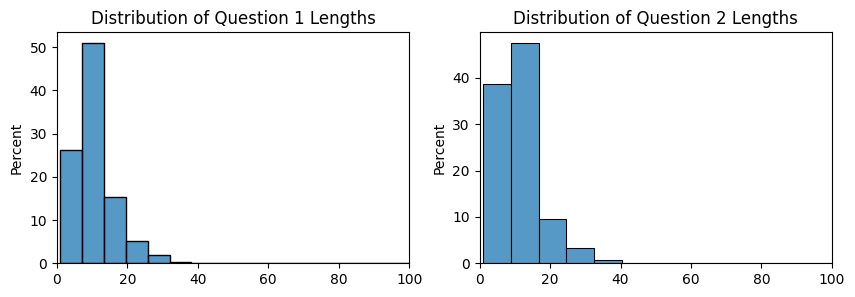

In [17]:
fig, axes = plt.subplots(nrows=1, ncols=2)

axes = axes.flatten()

fig.set_size_inches(10, 3)

sns.histplot(data=question1_lengths, stat="percent", bins=20, ax=axes[0])
axes[0].set_title("Distribution of Question 1 Lengths")
axes[0].set_xlim(0, 100)

sns.histplot(data=question2_lengths, stat="percent", bins=30, ax=axes[1])
axes[1].set_title("Distribution of Question 2 Lengths")
axes[1].set_xlim(0, 100)

plt.show()

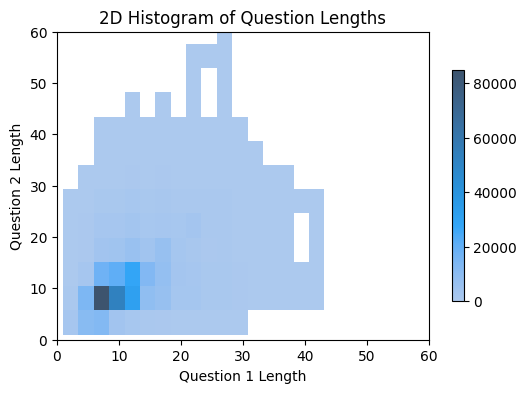

In [18]:
_ = pd.DataFrame({"question1": question1_lengths, "question2": question2_lengths})

fig, ax = plt.subplots(figsize=(6, 4))
sns.histplot(_, x="question1", y="question2", ax=ax, bins=50, thresh=30.0, cbar=True, cbar_kws=dict(shrink=.75))
ax.set_title("2D Histogram of Question Lengths")
ax.set_xlabel("Question 1 Length")
ax.set_ylabel("Question 2 Length")
ax.set_xlim(0, 60)
ax.set_ylim(0, 60)
plt.show()

In [19]:
ORIGINAL_QUESTION = "question1"
NEW_QUESTION = "question2"

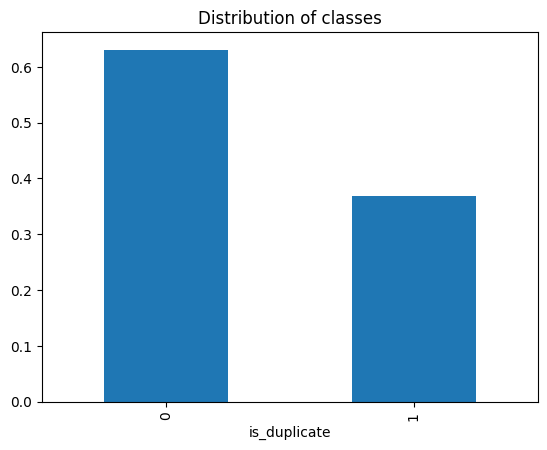

In [20]:
df_questions[TARGET].value_counts(normalize=True).plot(kind='bar', title="Distribution of classes")
plt.show()

- Most of the questions have a similar length and there are more negative samples than positive samples. Given that, accuracy is not the best metric and I'll use one that measures the probabilities (AUC Score) and other for after-threshold assessment (logloss).

# Preprocessing

In [21]:
df_questions = df_questions.dropna(subset=[ORIGINAL_QUESTION, NEW_QUESTION], axis=0, inplace=False)

In [22]:
df_questions.loc[:, ORIGINAL_QUESTION] = df_questions.loc[:, ORIGINAL_QUESTION].map(str.lower)
df_questions.loc[:, NEW_QUESTION] = df_questions.loc[:, NEW_QUESTION].map(str.lower)

In [23]:
df_questions = df_questions.loc[:, [ORIGINAL_QUESTION, NEW_QUESTION, TARGET]].copy()

In [24]:
df_questions.shape

(404287, 3)

In [25]:
df_questions.head(3)

,question1,question2,is_duplicate
0,what is the step by step guide to invest in share market in india?,what is the step by step guide to invest in share market?,0
1,what is the story of kohinoor (koh-i-noor) diamond?,what would happen if the indian government stole the kohinoor (koh-i-noor) diamond back?,0
2,how can i increase the speed of my internet connection while using a vpn?,how can internet speed be increased by hacking through dns?,0


# Model

## Considerations

- I will use the USE familify of models (specifically the USE base model in the second version from Kaggle).
- Consider that there are more versions that points to the tfhub in the link in the official documentation. But, some of those versions does not appear in Kaggle's Hub.
- Documentation available in the [official repo of Google TF Hub](https://github.com/tensorflow/tfhub.dev/blob/master/assets/docs/google/models/universal-sentence-encoder/3.md).
- Documentation in Kaggle [here](https://www.kaggle.com/models/google/universal-sentence-encoder/TensorFlow2/universal-sentence-encoder/2).

## Pre-trained model (USE)

In [26]:
MODEL_PATH = "https://www.kaggle.com/models/google/universal-sentence-encoder/TensorFlow2/universal-sentence-encoder/2"

In [27]:
import tensorflow_hub as hub

In [28]:
encoder = hub.load(MODEL_PATH)

In [29]:
def get_embeddings(text: List[str]) -> List[np.ndarray]:
    embeddings = encoder(text)
    return embeddings.numpy()

## Prepare dataset

In [30]:
from sklearn.model_selection import train_test_split

In [31]:
train, validation = train_test_split(df_questions, test_size=0.3, stratify=df_questions[TARGET], random_state=SEED)
validation, test = train_test_split(validation, test_size=0.5, stratify=validation[TARGET], random_state=SEED)

In [32]:
train.shape, validation.shape, test.shape

((283000, 3), (60643, 3), (60644, 3))

In [33]:
# # To accelerate the first iteration
# train = train.head(int(train.shape[0] * 0.01))
# validation = validation.head(int(validation.shape[0] * 0.01))
# test = test.head(int(test.shape[0] * 0.01))

In [34]:
train.shape, validation.shape, test.shape

((283000, 3), (60643, 3), (60644, 3))

In [35]:
train = train.reset_index(drop=True, inplace=False)
validation = validation.reset_index(drop=True, inplace=False)
test = test.reset_index(drop=True, inplace=False)

In [36]:
import torch
from datasets import Dataset, DatasetDict, Features, Value
from torch.utils.data import DataLoader

In [37]:
schema = Features({
    ORIGINAL_QUESTION: Value(dtype='string'),
    NEW_QUESTION: Value(dtype='string'),
    TARGET: Value(dtype='int32'),
})

In [38]:
class QuestionsDataset(pl.LightningDataModule):
    def __init__(
        self,
        df_train: pd.DataFrame,
        df_val: pd.DataFrame,
        df_test: pd.DataFrame,
        schema: Features,
        num_workers: int = 2,
        batch_size: int = 32,
        shuffle: bool = False
    ):
        super().__init__()
        self.df_train = df_train
        self.df_val = df_val
        self.df_test = df_test
        self.schema = schema
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.shuffle = shuffle
        self.pin_memory = torch.cuda.is_available()

    def format_data(self):
        self.dataset = DatasetDict({
            "train": Dataset.from_pandas(self.df_train, features=self.schema),
            "validation": Dataset.from_pandas(self.df_val, features=self.schema),
            "test": Dataset.from_pandas(self.df_test, features=self.schema),
        })

    def encode(self, batch):
        batch["original_question_embedding"] = get_embeddings(batch[ORIGINAL_QUESTION])
        batch["new_question_embedding"] = get_embeddings(batch[ORIGINAL_QUESTION])

        return batch

    def setup(self):
        self.train = self.dataset["train"].map(function=self.encode, batched=True, batch_size=self.batch_size)
        self.train.set_format(type="torch", columns=["original_question_embedding", "new_question_embedding", TARGET], output_all_columns=True)

        self.val = self.dataset["validation"].map(function=self.encode, batched=True, batch_size=self.batch_size)
        self.val.set_format(type="torch", columns=["original_question_embedding", "new_question_embedding", TARGET], output_all_columns=True)

        self.test = self.dataset["test"].map(function=self.encode, batched=True, batch_size=self.batch_size)
        self.test.set_format(type="torch", columns=["original_question_embedding", "new_question_embedding", TARGET], output_all_columns=True)

    def train_dataloader(self):
        return DataLoader(self.train,
                          batch_size=self.batch_size,
                          num_workers=self.num_workers,
                          pin_memory=self.pin_memory,
                          shuffle=self.shuffle)

    def val_dataloader(self):
        return DataLoader(self.val,
                          batch_size=self.batch_size,
                          num_workers=self.num_workers,
                          pin_memory=self.pin_memory,
                          shuffle=False)

    def test_dataloader(self):
        return DataLoader(self.test,
                          batch_size=self.batch_size,
                          num_workers=self.num_workers,
                          pin_memory=self.pin_memory,
                          shuffle=False)

In [39]:
data = QuestionsDataset(
    df_train=train,
    df_val=validation,
    df_test=test,
    schema=schema,
    batch_size=32,
    num_workers=1,
    shuffle=True
)

In [40]:
data.format_data()

In [41]:
data.setup()

Parameter 'function'=<bound method QuestionsDataset.encode of <__main__.QuestionsDataset object at 0x7b8680a87f70>> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


Map:   0%|          | 0/283000 [00:00<?, ? examples/s]

Map:   0%|          | 0/60643 [00:00<?, ? examples/s]

Map:   0%|          | 0/60644 [00:00<?, ? examples/s]

In [42]:
print(len(data.train))
print(len(data.val))
print(len(data.test))

283000
60643
60644


In [43]:
batch = next(iter(data.train_dataloader()))
# print(batch)
print(batch["original_question_embedding"].shape)  # Should be (batch_size, embedding_dim)
print(batch["new_question_embedding"].shape)      # Should be (batch_size, embedding_dim)
print(batch["is_duplicate"].shape)

torch.Size([32, 512])
torch.Size([32, 512])
torch.Size([32])


## English binary classifier

In [44]:
import torch.nn as nn
import torch.nn.functional as F
import evaluate

In [45]:
class SameIntentionDetector(pl.LightningModule):
    def __init__(
        self,
        hidden_dims: List[int] = [256, 128, 64],
        dropout_prob: float = 0.5,
        learning_rate: float = 1e-3
    ):
        super().__init__()
        self.train_auc = evaluate.load("roc_auc")
        self.val_auc = evaluate.load("roc_auc")
        self.test_auc = evaluate.load("roc_auc")
        self.train_f1 = evaluate.load("f1")
        self.val_f1 = evaluate.load("f1")
        self.test_f1 = evaluate.load("f1")
        self.hidden_dims = hidden_dims
        self.dropout_prob = dropout_prob
        self.learning_rate = learning_rate

        self.embedding_dim = 512 * 4

        layers = []
        prev_dim = self.embedding_dim

        for next_hidden_layer in hidden_dims:
            layers.append(nn.Linear(prev_dim, next_hidden_layer))
            layers.append(nn.ReLU())

            if dropout_prob > 0:
                layers.append(nn.Dropout(dropout_prob))

            prev_dim = next_hidden_layer

        layers.append(nn.Linear(prev_dim, 2))

        self.layers = nn.Sequential(*layers)

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.learning_rate)
        return optimizer

    def forward(self, x):
        logits = self.layers(x)
        return logits

    def __compute_loss(self, batch):
        x1 = batch["original_question_embedding"]
        x2 = batch["new_question_embedding"]
        y = batch[TARGET]

        diff = torch.abs(x1 - x2)
        prod = x1 * x2
        combined = torch.cat([x1, x2, diff, prod], dim=1)

        logits = self(combined)
        probs = F.softmax(logits, dim=-1)
        positive_probs = probs[:, 1]
        preds = torch.argmax(logits, dim=1).detach().cpu().numpy()
        loss = F.cross_entropy(logits, y)
        return loss, preds, y, positive_probs


    def training_step(self, batch, batch_idx):
        batch_size = batch["original_question_embedding"].size(0)

        loss, preds, y, probs = self.__compute_loss(batch)

        self.train_f1.add_batch(predictions=preds, references=y.detach().cpu().numpy())
        self.train_auc.add_batch(prediction_scores=probs.detach().cpu().numpy(), references=y.detach().cpu().numpy())

        f1 = self.train_f1.compute()["f1"]
        auc = self.train_auc.compute()["roc_auc"]

        values = {
            "train_loss": loss,
            "train_f1": f1,
            "train_auc": auc,
        }
        self.log_dict(values, on_step=True, on_epoch=True, prog_bar=True, logger=True, batch_size=batch_size)
        return loss

    def validation_step(self, batch, batch_idx):
        batch_size = batch["original_question_embedding"].size(0)

        loss, preds, y, probs = self.__compute_loss(batch)

        self.val_f1.add_batch(predictions=preds, references=y.detach().cpu().numpy())
        self.val_auc.add_batch(prediction_scores=probs.detach().cpu().numpy(), references=y.detach().cpu().numpy())

        f1 = self.val_f1.compute()["f1"]
        auc = self.val_auc.compute()["roc_auc"]

        values = {
            "val_loss": loss,
            "val_f1": f1,
            "val_auc": auc,
        }
        self.log_dict(values, on_step=True, on_epoch=True, prog_bar=True, logger=True, batch_size=batch_size)
        return loss

    def test_step(self, batch, batch_idx):
        batch_size = batch["original_question_embedding"].size(0)

        loss, preds, y, probs = self.__compute_loss(batch)

        self.train_f1.add_batch(predictions=preds, references=y.detach().cpu().numpy())
        self.train_auc.add_batch(prediction_scores=probs.detach().cpu().numpy(), references=y.detach().cpu().numpy())

        f1 = self.train_f1.compute()["f1"]
        auc = self.train_auc.compute()["roc_auc"]

        values= {
            "test_loss": loss,
            "test_f1": f1,
            "test_auc": auc
        }

        self.log_dict(values, on_step=True, on_epoch=True, prog_bar=True, logger=True, batch_size=batch_size)
        return loss

## Train

In [46]:
model = SameIntentionDetector(
    hidden_dims=[256, 128, 64],
    dropout_prob=0.5,
    learning_rate=1e-2
)

In [47]:
EPOCHS=10

In [48]:
checkpoint_callback = pl.callbacks.ModelCheckpoint(
    monitor="val_loss",
    dirpath="/content/drive/MyDrive/Colab Notebooks/Transformers/USE family/same-intention-detection/model",
    filename="same-intetion-detection-{epoch:02d}-{val_loss:.3f}",
    save_top_k=3,
    mode="min"
)

In [49]:
trainer = pl.Trainer(
    num_nodes=1,
    max_epochs=EPOCHS,
    callbacks=[checkpoint_callback]
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [50]:
trainer.fit(model, data.train_dataloader(), data.val_dataloader())

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /content/drive/MyDrive/Colab Notebooks/Transformers/USE family/same-intention-detection/model exists and is not empty.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name   | Type       | Params | Mode 
----------------------------------------------
0 | layers | Sequential | 565 K  | train
----------------------------------------------
565 K     Trainable params
0         Non-trainable params
565 K     Total params
2.263     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


## Test

In [51]:
trainer.test(dataloaders=data.test_dataloader())

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/checkpoint_connector.py:145: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/drive/MyDrive/Colab Notebooks/Transformers/USE family/same-intention-detection/model/same-intetion-detection-epoch=03-val_loss=0.659-v1.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from the checkpoint at /content/drive/MyDrive/Colab Notebooks/Transformers/USE family/same-intention-detection/model/same-intetion-detection-epoch=03-val_loss=0.659-v1.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_auc_epoch       │            0.5            │
│       test_f1_epoch       │            0.0            │
│      test_loss_epoch      │    0.6585385203361511     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss_epoch': 0.6585385203361511,
  'test_f1_epoch': 0.0,
  'test_auc_epoch': 0.5}]

## Inference

In [52]:
best_model = SameIntentionDetector.load_from_checkpoint(checkpoint_callback.best_model_path)

In [53]:
best_model.eval()

SameIntentionDetector(
  (layers): Sequential(
    (0): Linear(in_features=2048, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=256, out_features=128, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=128, out_features=64, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.5, inplace=False)
    (9): Linear(in_features=64, out_features=2, bias=True)
  )
)

In [54]:
def predict(original_question: str, new_question: str, probs: bool = False) -> dict:
    original_embedding = torch.Tensor(get_embeddings([original_question]))
    new_embedding = torch.Tensor(get_embeddings([new_question]))

    original_embedding = original_embedding.to(best_model.device)
    new_embedding = new_embedding.to(best_model.device)

    x1 = original_embedding
    x2 = new_embedding

    diff = torch.abs(x1 - x2)
    prod = x1 * x2
    combined = torch.cat([x1, x2, diff, prod], dim=1)

    logits = best_model(combined)

    preds = torch.argmax(logits, dim=1).detach().cpu().numpy()
    scores = torch.softmax(logits, dim=1).detach().cpu().numpy()

    positive_prob = scores.flatten().tolist()[1]

    if probs:
        return preds[0], positive_prob

    return preds[0]

In [55]:
predict("What kind of engineerings are there?", "I want to play basketball", probs=True)

(0, 0.36754557490348816)

In [56]:
predict("how does a long distance relationship work?", "how are long distance relationships maintained?", probs=True)

(0, 0.36754557490348816)